<h3> Machine Learning Project 6 </h3>
    <p> Liora Wachsstock </p>
    

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#constants
UPPER = 10
LOWER = -2

In [3]:
def generate_data(n):
    rng = np.random.default_rng()
    x = (UPPER - LOWER) * rng.random(n) + LOWER
    y = f(x)
    data = np.stack((x, y), axis=-1)
    
    return pd.DataFrame(data, columns=("X", "Y"))

def f(x):
    return np.square(x) + 10

#generate data
train = generate_data(12)
test = generate_data(5)

#check for intersecting values and re-sample if necessary
while (np.intersect1d(train.T[0], test.T[0]).size > 0): #only have to check if there are identical values in x values
    print(np.intersect1d(train.T[0], test.T[0]))
    test = generate_data(5)

print(train)
print(test)

           X           Y
0   6.820754   56.522683
1   5.489028   40.129433
2   9.883863  107.690742
3   4.671243   31.820511
4   9.789160  105.827661
5   8.430119   81.066901
6  -0.646799   10.418349
7  -1.317294   11.735264
8   4.642776   31.555371
9   4.036475   26.293133
10  7.037534   59.526878
11  4.747594   32.539645
          X          Y
0 -0.572107  10.327306
1 -1.562467  12.441303
2  8.899736  89.205299
3  8.886866  88.976390
4 -1.819827  13.311771


In [35]:
def quadratic_regression(data):
    #math from https://www.varsitytutors.com/hotmath/hotmath_help/topics/quadratic-regression
    
    powers = np.array([4,3,2,3,2,1,2,1,0])
    
    #repeat each of the x values 9 times for the powers
    x_s = np.repeat(np.array(data['X']), [powers.size]).reshape(data['X'].size, powers.size) 
    
    coeff_m = np.sum(np.power(x_s, powers), axis=0).reshape(3,3)
    
    y_col = np.vstack((np.sum(np.square(data['X'])*data['Y']), np.sum(data['X']*data['Y']), np.sum(data['Y'])))
    
    result = np.matmul(np.linalg.inv(coeff_m), y_col)
    print(result)
    return result

In [34]:
result = quadratic_regression(train)

[[1.00000000e+00]
 [6.39488462e-14]
 [1.00000000e+01]]


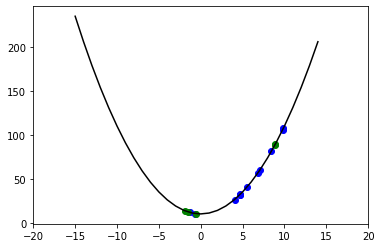

In [6]:
fig, ax = plt.subplots()
plt.xlim([-20,20])

def curve(abc):
    a,b,c = abc
    x = np.arange(-15, 15) #points on the curve
    y = a*np.square(x) + b*x +c #equation of the curve
    return x,y

x, y = curve(result)
ax.plot(x, y, 'k',label="f(x) = x^2 + 10")

ax.scatter(train['X'], train['Y'], c='b')
ax.scatter(test['X'], test['Y'], c='g')
plt.show()